In [9]:
import os
import json
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

from sklearn import model_selection, preprocessing, metrics
#import lightgbm as lgb
#import xgboost as xgb

from fastai.imports import *
from fastai.torch_imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
from fastai.structured import *
from fastai.column_data import *
PATH = 'data/'

import pytz # $ pip install pytz
from pytz import country_timezones
import pycountry

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

# Functions (Feature engineering)

In [52]:
PATH = 'data/'

#the columns that will be parsed to extract the fields from the jsons
cols_to_parse = ['device', 'geoNetwork', 'totals', 'trafficSource']
def read_parse_dataframe(file_name):
    #full path for the data file
    path = PATH + file_name
    #read the data file, convert the columns in the list of columns to parse using json loader,
    #convert the `fullVisitorId` field as a string
    data_df = pd.read_csv(path, 
        converters={column: json.loads for column in cols_to_parse}, 
        dtype={'fullVisitorId': 'str'})
    #parse the json-type columns
    for col in cols_to_parse:
        #each column became a dataset, with the columns the fields of the Json type object
        json_col_df = json_normalize(data_df[col])
        json_col_df.columns = [f"{col}_{sub_col}" for sub_col in json_col_df.columns]
        #we drop the object column processed and we add the columns created from the json fields
        data_df = data_df.drop(col, axis=1).merge(json_col_df, right_index=True, left_index=True)
    return data_df

def process_date_time(data_df):
    print("process date time ...")
    
    data_df['date'] = data_df['date'].astype(str)
    data_df["date"] = data_df["date"].apply(lambda x : x[:4] + "-" + x[4:6] + "-" + x[6:])
    data_df["date"] = pd.to_datetime(data_df["date"])   
    data_df["year"] = data_df['date'].dt.year
    data_df["month"] = data_df['date'].dt.month
    data_df["day"] = data_df['date'].dt.day
    data_df["weekday"] = data_df['date'].dt.weekday
    data_df['weekofyear'] = data_df['date'].dt.weekofyear
    data_df['month_unique_user_count'] = data_df.groupby('month')['fullVisitorId'].transform('nunique')
    data_df['day_unique_user_count'] = data_df.groupby('day')['fullVisitorId'].transform('nunique')
    data_df['weekday_unique_user_count'] = data_df.groupby('weekday')['fullVisitorId'].transform('nunique')
    data_df['month_unique_s_count'] = data_df.groupby('month')['sessionId'].transform('nunique')
    data_df['day_unique_s_count'] = data_df.groupby('day')['sessionId'].transform('nunique')
    data_df['weekday_unique_s_count'] = data_df.groupby('weekday')['sessionId'].transform('nunique')
    return data_df

def process_format(data_df):
    print("process format ...")
    
    for col in ['visitNumber', 'totals_hits', 'totals_pageviews']:
        data_df[col] = data_df[col].astype(float)
    data_df['trafficSource_adwordsClickInfo.isVideoAd'].fillna(True, inplace=True)
    data_df['trafficSource_isTrueDirect'].fillna(False, inplace=True)
    return data_df
    
def process_device(data_df):
    print("process device ...")
    
    data_df['browser_category'] = data_df['device_browser'] + '_' + data_df['device_deviceCategory']
    data_df['browser_operatingSystem'] = data_df['device_browser'] + '_' + data_df['device_operatingSystem']
    data_df['source_country'] = data_df['trafficSource_source'] + '_' + data_df['geoNetwork_country']
    return data_df

def process_geo_network(data_df):
    print("process geo network ...")
    
    data_df['sum_pageviews_per_network_domain'] = data_df.groupby('geoNetwork_networkDomain')['totals_pageviews'].transform('sum')
    data_df['count_pageviews_per_network_domain'] = data_df.groupby('geoNetwork_networkDomain')['totals_pageviews'].transform('count')
    data_df['mean_pageviews_per_network_domain'] = data_df.groupby('geoNetwork_networkDomain')['totals_pageviews'].transform('mean')
    data_df['sum_hits_per_network_domain'] = data_df.groupby('geoNetwork_networkDomain')['totals_hits'].transform('sum')
    data_df['count_hits_per_network_domain'] = data_df.groupby('geoNetwork_networkDomain')['totals_hits'].transform('count')
    data_df['mean_hits_per_network_domain'] = data_df.groupby('geoNetwork_networkDomain')['totals_hits'].transform('mean')
    return data_df

def process_geo_network_names(data_df):
    print("process geo network names ...")
    
    data_df['geoNetwork_country'][data_df['geoNetwork_country'] == '(not set)'] = float('NaN')
    data_df['geoNetwork_country'][data_df['geoNetwork_country'] == 'Russia'] = 'Russian Federation'
    data_df['geoNetwork_country'][data_df['geoNetwork_country'] == 'South Korea'] = 'Korea, Republic of'
    data_df['geoNetwork_country'][data_df['geoNetwork_country'] == 'Côte d’Ivoire'] = "Côte d'Ivoire"
    data_df['geoNetwork_country'][data_df['geoNetwork_country'] == 'Cape Verde'] = "Cabo Verde"
    data_df['geoNetwork_country'][data_df['geoNetwork_country'] == 'Macedonia (FYROM)'] = "Macedonia, Republic of"
    data_df['geoNetwork_country'][data_df['geoNetwork_country'] == 'Myanmar (Burma)'] = "Myanmar"
    data_df['geoNetwork_country'][data_df['geoNetwork_country'] == 'Kosovo'] = "Serbia"
    data_df['geoNetwork_country'][data_df['geoNetwork_country'] == 'Laos'] = "Thailand"
    data_df['geoNetwork_country'][data_df['geoNetwork_country'] == 'Turks & Caicos Islands'] = "Turks and Caicos Islands"
    data_df['geoNetwork_country'][data_df['geoNetwork_country'] == 'Palestine'] = "Palestine, State of"
    data_df['geoNetwork_country'][data_df['geoNetwork_country'] == 'Congo - Kinshasa'] = "Congo, The Democratic Republic of the"
    data_df['geoNetwork_country'][data_df['geoNetwork_country'] == 'Macau'] = "Hong Kong"
    data_df['geoNetwork_country'][data_df['geoNetwork_country'] == 'Brunei'] = "Brunei Darussalam"
    data_df['geoNetwork_country'][data_df['geoNetwork_country'] == 'Sint Maarten'] = "Sint Maarten (Dutch part)"
    data_df['geoNetwork_country'][data_df['geoNetwork_country'] == 'Iran'] = "Iran, Islamic Republic of"
    data_df['geoNetwork_country'][data_df['geoNetwork_country'] == 'Saint Vincent and Grenadines'] = \
                                                                   "Saint Vincent and the Grenadines"
    data_df['geoNetwork_country'][data_df['geoNetwork_country'] == 'U.S. Virgin Islands'] = "Virgin Islands, U.S."
    data_df['geoNetwork_country'][data_df['geoNetwork_country'] == 'Syria'] = "Syrian Arab Republic"
    data_df['geoNetwork_country'][data_df['geoNetwork_country'] == 'Caribbean Netherlands'] = "Venezuela, Bolivarian Republic of"
    data_df['geoNetwork_country'][data_df['geoNetwork_country'] == 'Congo - Brazzaville'] = \
                                                                   "Congo, The Democratic Republic of the"
    data_df['geoNetwork_country'][data_df['geoNetwork_country'] == 'Saint Martin'] = "Saint Martin (French part)"
    data_df['geoNetwork_country'][data_df['geoNetwork_country'] == 'São Tomé and Príncipe'] = "Sao Tome and Principe"
    data_df['geoNetwork_country'][data_df['geoNetwork_country'] == 'Saint Helena'] =  \
                                                                   "Saint Helena, Ascension and Tristan da Cunha"
    data_df['geoNetwork_country'][data_df['geoNetwork_country'] == 'Micronesia'] = "Micronesia, Federated States of"
 
    
    return data_df

def process_geo_network_names_with_mask(data_df, mask):
    print("process geo network names with mask ...")
    
    data_df['geoNetwork_country'] = data_df['geoNetwork_country'][mask].apply(lambda x: x.replace('&','and'))
    data_df['geoNetwork_country'] = data_df['geoNetwork_country'][mask].apply(lambda x: x.replace('St.','Saint'))
    return data_df
    
def process_geo_timezone(data_df, mask):
    print("process geo timezone ...")
    
    data_df['geoNetwork_country'] = data_df[mask]['geoNetwork_country'].apply(lambda x: pycountry.countries.lookup(x).alpha_2)
    data_df['time'] = pd.to_datetime(data_df['visitStartTime'], unit='s')
    data_df['time'] = data_df[mask].apply(lambda x: x['time'].tz_localize( \
                     country_timezones(x['geoNetwork_country'])[0], errors='coerce', ambiguous='NaT'), axis=1)
    data_df['time'] = data_df['time'].astype(str).str[:-6]
    data_df['time'] = pd.to_datetime(data_df['time'])
    return data_df

def process_unique_user_per_span(data_df):
    data_df['month_unique_user_count'] = data_df.groupby('timeMonth')['fullVisitorId'].transform('nunique')
    data_df['day_unique_user_count'] = data_df.groupby('timeDay')['fullVisitorId'].transform('nunique')
    data_df['weekday_unique_user_count'] = data_df.groupby('timeDayofweek')['fullVisitorId'].transform('nunique')
    data_df['month_unique_s_count'] = data_df.groupby('timeMonth')['sessionId'].transform('nunique')
    data_df['day_unique_s_count'] = data_df.groupby('timeDay')['sessionId'].transform('nunique')
    data_df['weekday_unique_s_count'] = data_df.groupby('timeDayofweek')['sessionId'].transform('nunique')
    return data_df

def process_totals(data_df):
    print("process totals ...")
    
    data_df['totals_hits'] = np.log1p(data_df['totals_hits'])
    data_df['totals_pageviews'] = np.log1p(data_df['totals_pageviews'].fillna(0))
    data_df['mean_hits_per_day'] = data_df.groupby(['timeDay'])['totals_hits'].transform('mean')
    data_df['sum_hits_per_day'] = data_df.groupby(['timeDay'])['totals_hits'].transform('sum')
    data_df['max_hits_per_day'] = data_df.groupby(['timeDay'])['totals_hits'].transform('max')
    data_df['min_hits_per_day'] = data_df.groupby(['timeDay'])['totals_hits'].transform('min')
    data_df['var_hits_per_day'] = data_df.groupby(['timeDay'])['totals_hits'].transform('var')
    return data_df

## Load data

In [38]:
train_df = read_parse_dataframe('train.csv')
#train_df = process_date_time(train_df)
test_df = read_parse_dataframe('test.csv')
#test_df = process_date_time(test_df)

## Drop columns columns with single unique

In [39]:
cols_to_drop = [col for col in train_df.columns if train_df[col].nunique(dropna=False) == 1]
train_df.drop(cols_to_drop, axis=1, inplace=True)
test_df.drop([col for col in cols_to_drop if col in test_df.columns], axis=1, inplace=True)

## Drop only one not null unique value

In [43]:
train_df.drop(['trafficSource_campaignCode'], axis=1, inplace=True)

KeyError: "['trafficSource_campaignCode'] not found in axis"

## Convert transactionRevenue

In [44]:
train_df['totals_transactionRevenue'] = train_df['totals_transactionRevenue'].astype(float)
train_df['totals_transactionRevenue'] = train_df['totals_transactionRevenue'].fillna(0)
train_df['totals_transactionRevenue'] = np.log1p(train_df['totals_transactionRevenue'])

In [46]:
train_df.to_pickle("train_df")
test_df.to_pickle("test_df")

In [53]:
train_df = pd.read_pickle("train_df")
test_df = pd.read_pickle("test_df")

# Features

In [54]:
train_df = process_format(train_df)
train_df = process_device(train_df)
#train_df = process_totals(train_df)
train_df = process_geo_network(train_df)

mask = train_df['geoNetwork_country'].notnull()
train_df = process_geo_network_names_with_mask(train_df, mask) 
train_df = process_geo_network_names(train_df)
mask = train_df['geoNetwork_country'].notnull() #some values are set to NaN after process geo names TODO: find out why
train_df = process_geo_network_names_with_mask(train_df, mask)
train_df = process_geo_timezone(train_df, mask)

train_df['time'][train_df['time'].isna()] = pd.to_datetime(train_df['visitStartTime'], unit='s')

process format ...
process device ...
process geo network ...
process geo network names with mask ...
process geo network names ...
process geo network names with mask ...
process geo timezone ...


In [55]:
test_df = process_format(test_df)
test_df = process_device(test_df)
#test_df = process_totals(test_df)
test_df = process_geo_network(test_df)

mask = test_df['geoNetwork_country'].notnull()
test_df = process_geo_network_names_with_mask(test_df, mask)
test_df = process_geo_network_names(test_df)
mask = test_df['geoNetwork_country'].notnull()  #some values are set to NaN after process geo names TODO: find out why
test_df = process_geo_network_names_with_mask(test_df, mask)
test_df = process_geo_timezone(test_df, mask)

test_df['time'][train_df['time'].isna()] = pd.to_datetime(train_df['visitStartTime'], unit='s')

process format ...
process device ...
process geo network ...
process geo network names with mask ...
process geo network names ...
process geo network names with mask ...
process geo timezone ...


In [56]:
train_df['timezone_date'] = train_df['time'].dt.normalize()
test_df['timezone_date'] = test_df['time'].dt.normalize()

In [57]:
add_datepart(train_df, "time", time=True, drop=False)
add_datepart(test_df, "time", time=True, drop=False)

In [58]:
train_df = process_unique_user_per_span(train_df)
test_df = process_unique_user_per_span(test_df)
train_df = process_totals(train_df)
test_df = process_totals(test_df)

process totals ...
process totals ...


In [59]:
col_x = ['sum_pageviews_per_network_domain', 'sum_hits_per_network_domain',
       'mean_hits_per_network_domain',
       'mean_pageviews_per_network_domain', 'totals_hits',
       'totals_pageviews']

for i in col_x:
    train_df[i+'_square'] =  train_df[i] ** 2
    test_df[i+'_square']  = test_df[i] ** 2

In [60]:
pd.set_option('display.max_rows', 1000) 
train_df.isna().sum()

channelGrouping                                      0
date                                                 0
fullVisitorId                                        0
sessionId                                            0
visitId                                              0
visitNumber                                          0
visitStartTime                                       0
device_browser                                       0
device_deviceCategory                                0
device_isMobile                                      0
device_operatingSystem                               0
geoNetwork_city                                      0
geoNetwork_continent                                 0
geoNetwork_country                                1468
geoNetwork_metro                                     0
geoNetwork_networkDomain                             0
geoNetwork_region                                    0
geoNetwork_subContinent                              0
totals_bou

In [61]:
train_df.nunique(dropna=True)

channelGrouping                                      8
date                                               366
fullVisitorId                                   714167
sessionId                                       902755
visitId                                         886303
visitNumber                                        384
visitStartTime                                  887159
device_browser                                      54
device_deviceCategory                                3
device_isMobile                                      2
device_operatingSystem                              20
geoNetwork_city                                    649
geoNetwork_continent                                 6
geoNetwork_country                                 216
geoNetwork_metro                                    94
geoNetwork_networkDomain                         28064
geoNetwork_region                                  376
geoNetwork_subContinent                             23
totals_bou

# Splitting Data into Categorical/Numerical

In [62]:
num_cols = ['month_unique_user_count', 'day_unique_user_count', 'weekday_unique_user_count', 'weekday_unique_s_count',
            'totals_hits', 'totals_pageviews', 'month_unique_s_count', 'day_unique_s_count',
            'mean_hits_per_day', 'sum_hits_per_day', 'max_hits_per_day', 'var_hits_per_day',
            'sum_pageviews_per_network_domain', 'count_pageviews_per_network_domain', 'mean_pageviews_per_network_domain',
            'sum_hits_per_network_domain', 'count_hits_per_network_domain', 'mean_hits_per_network_domain',
            'sum_pageviews_per_network_domain_square', 'sum_hits_per_network_domain_square', 
            'mean_hits_per_network_domain_square', 'mean_pageviews_per_network_domain_square', 
            'totals_hits_square', 'totals_pageviews_square']
            
not_used_cols = ["visitNumber", "fullVisitorId", "sessionId", "visitId", "visitStartTime", 
                 'trafficSource_referralPath', "date", "timezone_date", "time", "fullVisitorId", 'totals_transactionRevenue']
cat_cols = [col for col in train_df.columns if col not in num_cols and col not in not_used_cols]

In [63]:
train_df.shape, test_df.shape, len(num_cols) + len(cat_cols)

((903653, 79), (804684, 78), 69)

# Prepare data for model

In [64]:
# Model
print("prepare model ...")
train_df = train_df.sort_values('timezone_date')
test_df = test_df.sort_values('timezone_date')
dep = 'totals_transactionRevenue'
test_df[dep] = 0
X = train_df[cat_cols + num_cols + [dep, 'timezone_date']].copy()
X_test = test_df[cat_cols + num_cols + [dep, 'timezone_date', 'fullVisitorId']].copy()


prepare model ...


In [65]:
X.shape, X_test.shape, len(num_cols) + len(cat_cols)

((903653, 71), (804684, 72), 69)

In [66]:
print("Column difference before copy/after copy : ", set(train_df.columns).difference(set(X.columns)))

Column difference before copy/after copy :  {'visitNumber', 'date', 'trafficSource_referralPath', 'visitId', 'visitStartTime', 'sessionId', 'time', 'fullVisitorId'}


In [67]:
print("Number of unique visitors in train set : ",train_df.fullVisitorId.nunique(), " out of rows : ",train_df.shape[0])
print("Number of unique visitors in train set : ",test_df.fullVisitorId.nunique(), " out of rows : ",test_df.shape[0])
print("Number of common visitors in train and test set : ",len(set(train_df.fullVisitorId.unique()).intersection(set(test_df.fullVisitorId.unique())) ))

Number of unique visitors in train set :  714167  out of rows :  903653
Number of unique visitors in train set :  617242  out of rows :  804684
Number of common visitors in train and test set :  7679


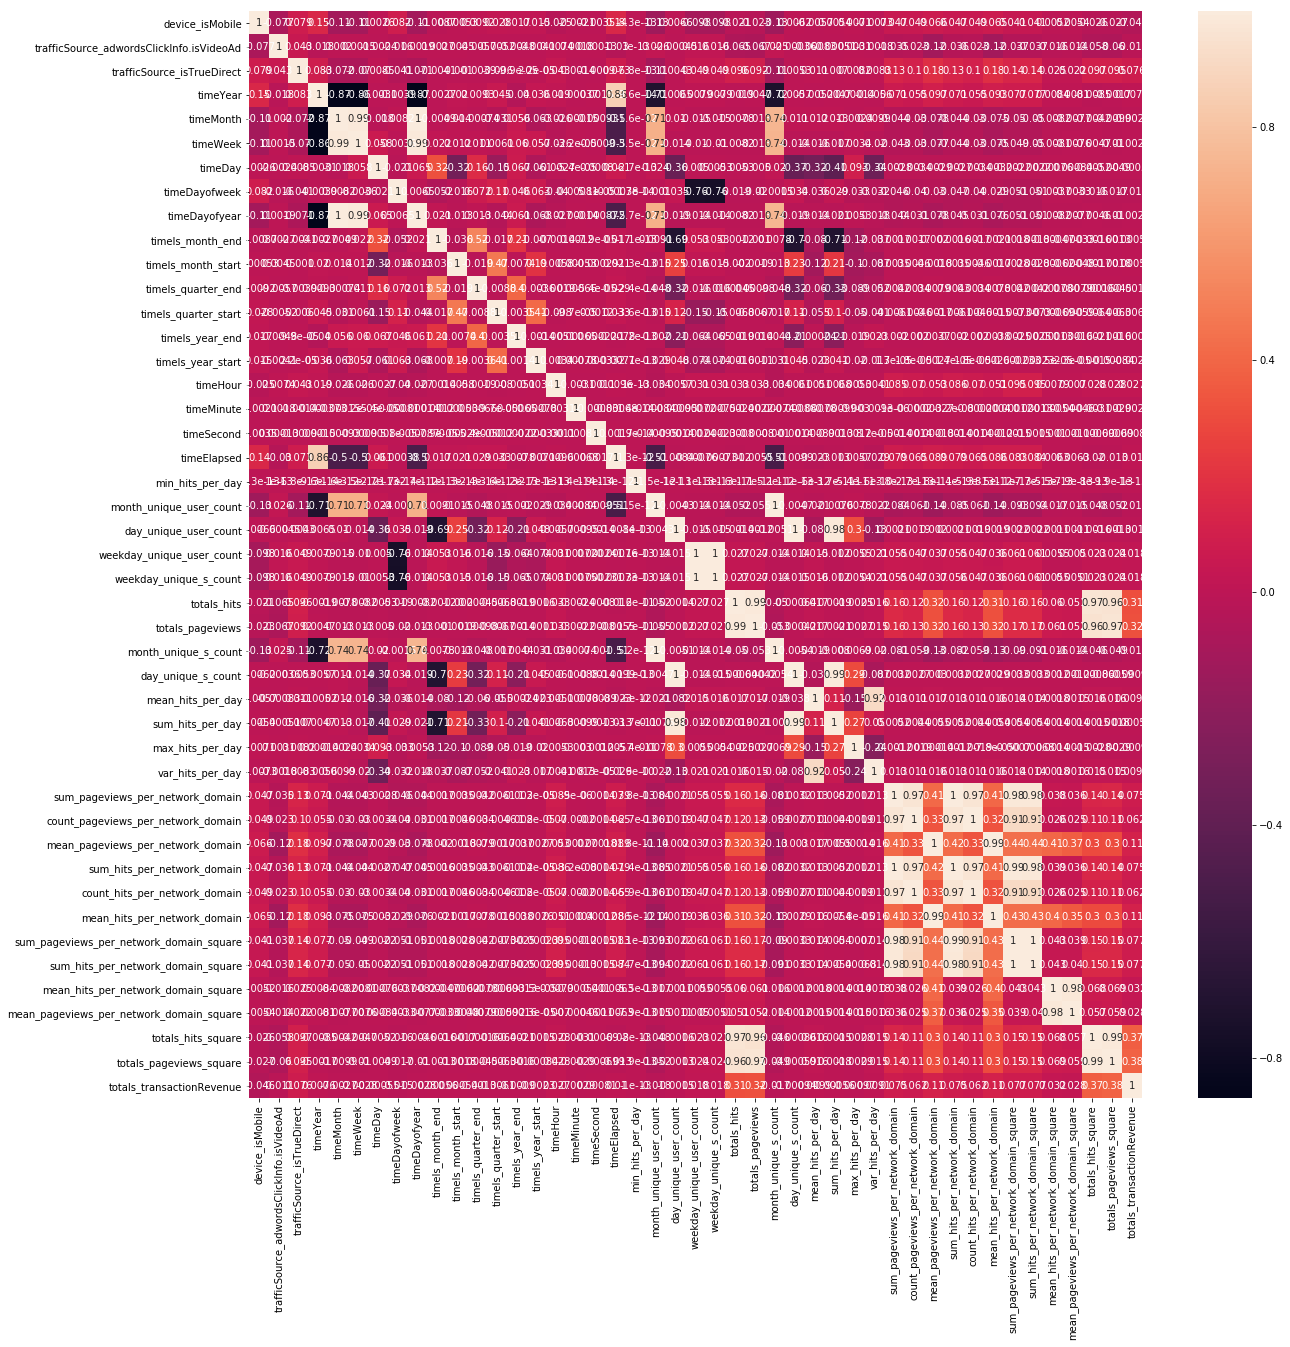

In [68]:
plt.figure(figsize=(20,20))
sns.heatmap(X.corr(),annot=True)

In [69]:
print("Variables not in test but in train : ", set(X.columns).difference(set(X_test.columns)))

Variables not in test but in train :  set()


In [70]:
print("Variables not in train but in test : ", set(X_test.columns).difference(set(X.columns)))

Variables not in train but in test :  {'fullVisitorId'}


In [71]:
X.to_pickle("train_df")
X_test.to_pickle("test_df")

In [ ]:
X = pd.read_pickle("train_df")
X_test = pd.read_pickle("test_df")

In [72]:
for v in cat_cols:
    print(v)
    X[v] = X[v].astype('category').cat.as_ordered()

channelGrouping
device_browser
device_deviceCategory
device_isMobile
device_operatingSystem
geoNetwork_city
geoNetwork_continent
geoNetwork_country
geoNetwork_metro
geoNetwork_networkDomain
geoNetwork_region
geoNetwork_subContinent
totals_bounces
totals_newVisits
trafficSource_adContent
trafficSource_adwordsClickInfo.adNetworkType
trafficSource_adwordsClickInfo.gclId
trafficSource_adwordsClickInfo.isVideoAd
trafficSource_adwordsClickInfo.page
trafficSource_adwordsClickInfo.slot
trafficSource_campaign
trafficSource_isTrueDirect
trafficSource_keyword
trafficSource_medium
trafficSource_source
browser_category
browser_operatingSystem
source_country
timeYear
timeMonth
timeWeek
timeDay
timeDayofweek
timeDayofyear
timeIs_month_end
timeIs_month_start
timeIs_quarter_end
timeIs_quarter_start
timeIs_year_end
timeIs_year_start
timeHour
timeMinute
timeSecond
timeElapsed
min_hits_per_day


In [73]:
X.columns.duplicated()

array([False, False, False, False, False, False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False, False, False, False, False, False,
       False])

In [74]:
apply_cats(X_test, X)

In [75]:
num_cols

['month_unique_user_count',
 'day_unique_user_count',
 'weekday_unique_user_count',
 'weekday_unique_s_count',
 'totals_hits',
 'totals_pageviews',
 'month_unique_s_count',
 'day_unique_s_count',
 'mean_hits_per_day',
 'sum_hits_per_day',
 'max_hits_per_day',
 'var_hits_per_day',
 'sum_pageviews_per_network_domain',
 'count_pageviews_per_network_domain',
 'mean_pageviews_per_network_domain',
 'sum_hits_per_network_domain',
 'count_hits_per_network_domain',
 'mean_hits_per_network_domain',
 'sum_pageviews_per_network_domain_square',
 'sum_hits_per_network_domain_square',
 'mean_hits_per_network_domain_square',
 'mean_pageviews_per_network_domain_square',
 'totals_hits_square',
 'totals_pageviews_square']

In [76]:
for v in num_cols:
    X[v] = X[v].astype('float32')
    X_test[v] = X_test[v].astype('float32')
    

X[dep] = X[dep].astype('float32')
X_test[dep] = X_test[dep].astype('float32')

In [77]:
X_indexed = X.set_index("timezone_date")

In [78]:
X_indexed.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 903653 entries, 2016-08-01 to 2017-08-02
Data columns (total 70 columns):
channelGrouping                                 903653 non-null category
device_browser                                  903653 non-null category
device_deviceCategory                           903653 non-null category
device_isMobile                                 903653 non-null category
device_operatingSystem                          903653 non-null category
geoNetwork_city                                 903653 non-null category
geoNetwork_continent                            903653 non-null category
geoNetwork_country                              902185 non-null category
geoNetwork_metro                                903653 non-null category
geoNetwork_networkDomain                        903653 non-null category
geoNetwork_region                               903653 non-null category
geoNetwork_subContinent                         903653 non-null catego

## Create Dataframes for deep-learning

In [79]:
df, y, nas, mapper = proc_df(X_indexed, 'totals_transactionRevenue', do_scale=True)

In [80]:
X_test_indexed = X_test.set_index("timezone_date")

In [81]:
df_test, _, nas, mapper = proc_df(X_test_indexed, 'totals_transactionRevenue', do_scale=True, 
                                  skip_flds=['fullVisitorId'], mapper=mapper, na_dict=nas)

In [82]:
n = len(df)
samp_size = n

In [83]:
train_ratio = 0.8
train_size = int(samp_size * train_ratio)
val_idx = list(range(train_size, len(df))); len(val_idx)

180731

In [84]:
max_y = np.max(y)

y_range = (0, max_y*1.2)

In [85]:
md = ColumnarModelData.from_data_frame(PATH, val_idx, df, y, cat_flds=cat_cols, bs=256, test_df=df_test)

In [86]:
cat_sz = [(c, len(X[c].cat.categories)+1) for c in cat_cols]
cat_sz

[('channelGrouping', 9),
 ('device_browser', 55),
 ('device_deviceCategory', 4),
 ('device_isMobile', 3),
 ('device_operatingSystem', 21),
 ('geoNetwork_city', 650),
 ('geoNetwork_continent', 7),
 ('geoNetwork_country', 217),
 ('geoNetwork_metro', 95),
 ('geoNetwork_networkDomain', 28065),
 ('geoNetwork_region', 377),
 ('geoNetwork_subContinent', 24),
 ('totals_bounces', 2),
 ('totals_newVisits', 2),
 ('trafficSource_adContent', 45),
 ('trafficSource_adwordsClickInfo.adNetworkType', 3),
 ('trafficSource_adwordsClickInfo.gclId', 17775),
 ('trafficSource_adwordsClickInfo.isVideoAd', 3),
 ('trafficSource_adwordsClickInfo.page', 9),
 ('trafficSource_adwordsClickInfo.slot', 3),
 ('trafficSource_campaign', 11),
 ('trafficSource_isTrueDirect', 3),
 ('trafficSource_keyword', 3660),
 ('trafficSource_medium', 8),
 ('trafficSource_source', 381),
 ('browser_category', 91),
 ('browser_operatingSystem', 120),
 ('source_country', 3400),
 ('timeYear', 3),
 ('timeMonth', 13),
 ('timeWeek', 53),
 ('time

In [87]:
emb_szs = [(c, max(10, min(50, (c+1)//2))) for _,c in cat_sz]
emb_szs

[(9, 10),
 (55, 28),
 (4, 10),
 (3, 10),
 (21, 11),
 (650, 50),
 (7, 10),
 (217, 50),
 (95, 48),
 (28065, 50),
 (377, 50),
 (24, 12),
 (2, 10),
 (2, 10),
 (45, 23),
 (3, 10),
 (17775, 50),
 (3, 10),
 (9, 10),
 (3, 10),
 (11, 10),
 (3, 10),
 (3660, 50),
 (8, 10),
 (381, 50),
 (91, 46),
 (120, 50),
 (3400, 50),
 (3, 10),
 (13, 10),
 (53, 27),
 (32, 16),
 (8, 10),
 (367, 50),
 (3, 10),
 (3, 10),
 (3, 10),
 (3, 10),
 (3, 10),
 (3, 10),
 (25, 13),
 (61, 31),
 (61, 31),
 (887160, 50),
 (2, 10)]

In [88]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_cols),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)

## Learning Rate finder

epoch      trn_loss   val_loss                                                                                         
    0      3.68207    4.677502  



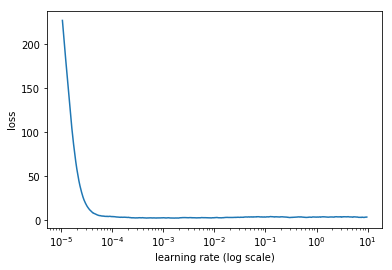

In [89]:
m.lr_find()
m.sched.plot()

In [91]:
lr = 10**-4.7
lr

1.9952623149688786e-05

## Learning

In [92]:
from sklearn.metrics import mean_squared_error

def exp_rmse(y_pred, targ):
    return math.sqrt(mean_squared_error(targ, y_pred))

In [ ]:
m.fit(lr, 1, cycle_len = 3, metrics=[exp_rmse])

 66%|████████████████████████████████████████████                       | 1855/2824 [01:47<00:56, 17.27it/s, loss=3.87]

In [ ]:
m.save("customer_revenue_3e")

In [ ]:
m.load("customer_revenue_3e")

In [ ]:
m.fit(lr, 2, cycle_len = 2, metrics=[exp_rmse])

In [ ]:
m.save("customer_revenue_7e")

In [ ]:
m.load("customer_revenue_7e")

In [ ]:
m.fit(lr, 2, cycle_len = 2, cycle_mult = 2, metrics=[exp_rmse])

In [ ]:
m.save("customer_revenue_7e_6em")

In [ ]:
m.load("customer_revenue_7e_6em")

In [ ]:
m.fit(lr, 2, cycle_len = 3, cycle_mult = 2, metrics=[exp_rmse])

In [ ]:
m.save("customer_revenue_7e_15em")

In [ ]:
m.load("customer_revenue_7e_15em")

# Creating Submission

In [ ]:
x,y=m.predict_with_targs()
x = torch.from_numpy(x)
y = torch.from_numpy(y)

In [ ]:
exp_rmse(x,y)

In [ ]:
log_preds = m.predict(True)

log_preds

In [ ]:
test['PredictedLogRevenue'] = log_preds 

In [ ]:
len(test['fullVisitorId'].unique())

In [ ]:
test_grouped = test.groupby(['fullVisitorId'], as_index=False).agg({'PredictedLogRevenue':'sum'})

In [ ]:
csv_fn=f'{PATH}submission.csv'

test_grouped[['fullVisitorId','PredictedLogRevenue']].to_csv(csv_fn, index=False)

test_grouped